In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf

ticker = "ANTM.JK"

# Ticker = yf.Ticker(ticker)
# price_history = Ticker.history(period="4y")
# price_history.to_csv(f'{ticker}_price_history_4tahun.csv')

In [3]:
# price_history = pd.read_csv(f'ANTM.JK_price_history_max.csv')
price_history = pd.read_csv('ANTM.JK_price_history_4tahun.csv')
# price_history = pd.read_csv(f'ANTM.JK_price_history_1y.csv')
# price_history = pd.read_csv('ANTM.JK_price_history_10tahun.csv')

In [6]:
price_history.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-05-14 00:00:00+07:00,495.233448,513.921503,476.545394,481.217407,81959800,0.0,0.0
1,2020-05-15 00:00:00+07:00,490.561387,495.233400,471.873334,485.889374,67020800,0.0,0.0
2,2020-05-18 00:00:00+07:00,490.561401,499.905428,485.889388,490.561401,46702500,0.0,0.0
3,2020-05-19 00:00:00+07:00,499.905428,509.249455,490.561401,490.561401,61033100,0.0,0.0
4,2020-05-20 00:00:00+07:00,495.233400,499.905413,476.545347,485.889374,41916400,0.0,0.0


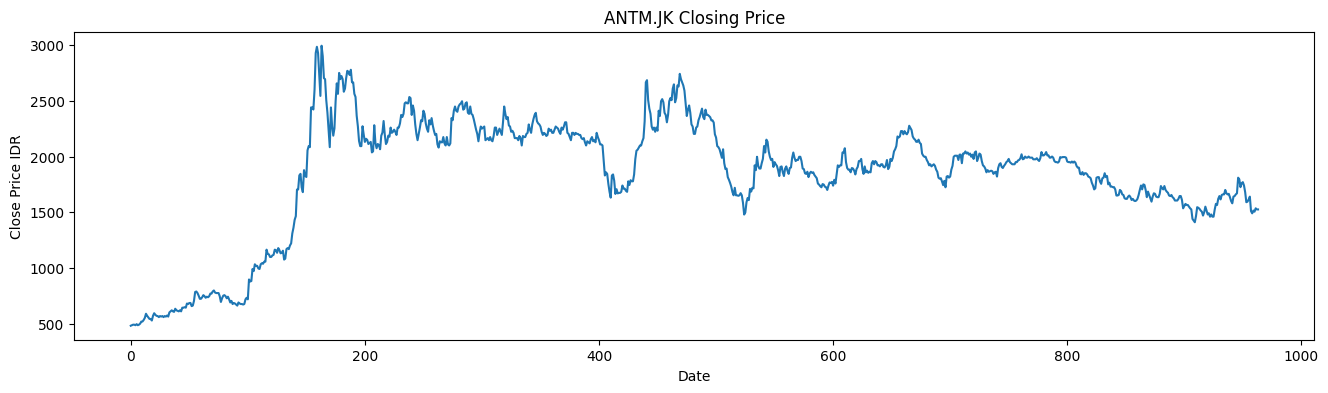

In [5]:
plt.figure(figsize=(16, 4))
plt.title(f'{ticker} Closing Price')
plt.plot(price_history['Close'])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
# plt.legend(['Train'], loc='upper left')
plt.show()

In [71]:
def split_data(data, test_size=0.2):
  data_size = len(data)
  train_size = int(data_size * (1 - test_size))

  data_train = data[:train_size]
  data_test = data[train_size:]

  return data_train, data_test

In [72]:
import numpy as np

def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [73]:
price_data_train, price_data_test = split_data(price_history, test_size=0.2) 

In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_price_train = scaler.fit_transform(price_data_train['Close'].values.reshape(-1, 1))
scaled_price_test = scaler.fit_transform(price_data_test['Close'].values.reshape(-1, 1))

In [75]:
SEQUENCE_LENGTH = 30 # Prediction time window

X_train, y_train = create_sequences(scaled_price_train, seq_length=SEQUENCE_LENGTH)
X_test, y_test = create_sequences(scaled_price_test, seq_length=SEQUENCE_LENGTH)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM

In [76]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras import optimizers

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16))
model.add(Dense(1))

opt = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse')

# model.compile(optimizer='adam', loss='mse') # default lr = 10e-3

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 30, 128)           33792     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 76065 (297.13 KB)
Trainable params: 76065 (297.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [77]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    ModelCheckpoint(filepath='model.weights.h5', monitor='loss', save_weights_only=True)
]

history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 6s 77ms/step - loss: 0.1167 - val_loss: 0.0111
Epoch 2/30
24/24 [==============================] - 1s 30ms/step - loss: 0.0073 - val_loss: 0.0098
Epoch 3/30
24/24 [==============================] - 1s 35ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 4/30
24/24 [==============================] - 1s 33ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 5/30
24/24 [==============================] - 1s 33ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 6/30
24/24 [==============================] - 1s 30ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 7/30
24/24 [==============================] - 1s 31ms/step - loss: 0.0020 - val_loss: 0.0050
Epoch 8/30
24/24 [==============================] - 1s 33ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/30
24/24 [==============================] - 1s 30ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 10/30
24/24 [==============================] - 1s 31ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/

In [78]:
# LSTM prediction

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE LSTM  : {mse:.7f}")
print(f"RMSE LSTM : {rmse:.7f}")
print(f"MAE LSTM  : {mae:.7f}")


6/6 [==============================] - 1s 10ms/step
MSE LSTM  : 0.0016985
RMSE LSTM : 0.0412128
MAE LSTM  : 0.0315905


In [79]:
y_pred_rescaled = scaler.inverse_transform(y_pred) 

In [80]:
train_size = len(price_data_train)
train_price_plot = price_history[:train_size + SEQUENCE_LENGTH]
test_price_plot = price_history[train_size + SEQUENCE_LENGTH:]
test_price_plot['Prediction'] = y_pred_rescaled.flatten()

/tmp/ipykernel_960/1873714381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_price_plot['Prediction'] = y_pred_rescaled.flatten()


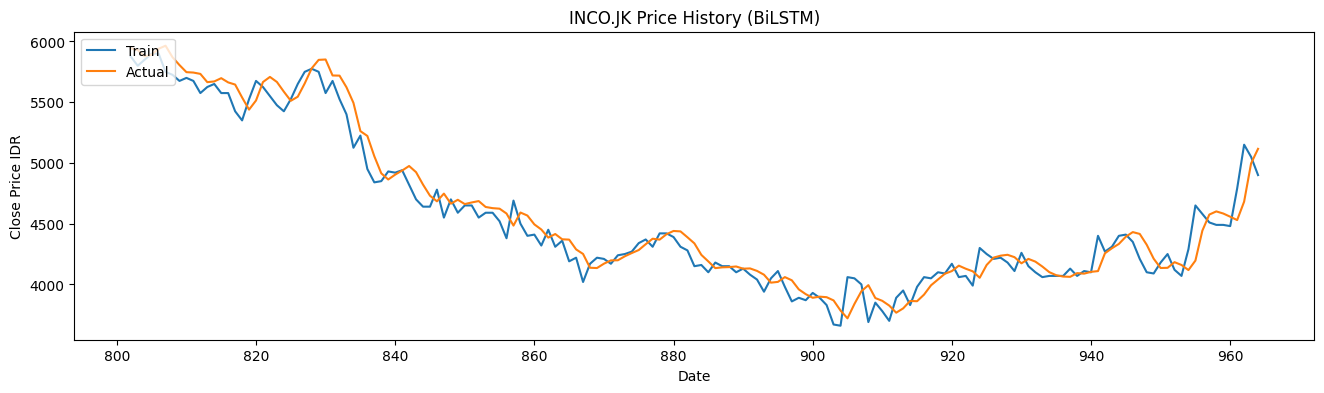

In [81]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 4))
plt.title(f'{ticker} Price History (BiLSTM)')
# plt.plot(train_price_plot['Close'])
plt.plot(test_price_plot[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
plt.legend(['Train', 'Actual', 'Prediction'], loc='upper left')
plt.show()

# RandomForestRegressor

In [82]:
from sklearn.ensemble import RandomForestRegressor

X_train_2d = X_train.squeeze()
y_train_1d = y_train.squeeze()

rf = RandomForestRegressor(n_estimators= 100, random_state=42, max_depth=5)
rf.fit(X_train_2d, y_train_1d)

RandomForestRegressor(max_depth=5, random_state=42)

In [83]:
print([estimator.tree_.max_depth for estimator in rf.estimators_])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [84]:
# print the random forest n_estimators
print(rf.n_estimators)

100


In [85]:
X_test_2d = X_test.squeeze()

y_pred_rf = rf.predict(X_test_2d)
y_test_1d = y_test.squeeze()

mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)

print(f"MSE RF  : {mse:.7f}")
print(f"RMSE RF : {rmse:.7f}")
print(f"MAE RF  : {mae:.7f}")


MSE RF  : 0.0018361
RMSE RF : 0.0428501
MAE RF  : 0.0316425


In [86]:
y_pred_rescaled_rf = scaler.inverse_transform(y_pred_rf.reshape(-1, 1))

In [87]:
train_size = len(price_data_train)
train_price_plot_rf = price_history[:train_size + SEQUENCE_LENGTH]
test_price_plot_rf = price_history[train_size + SEQUENCE_LENGTH:]
test_price_plot_rf['Prediction'] = y_pred_rescaled_rf.flatten()

/tmp/ipykernel_960/11579854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_price_plot_rf['Prediction'] = y_pred_rescaled_rf.flatten()


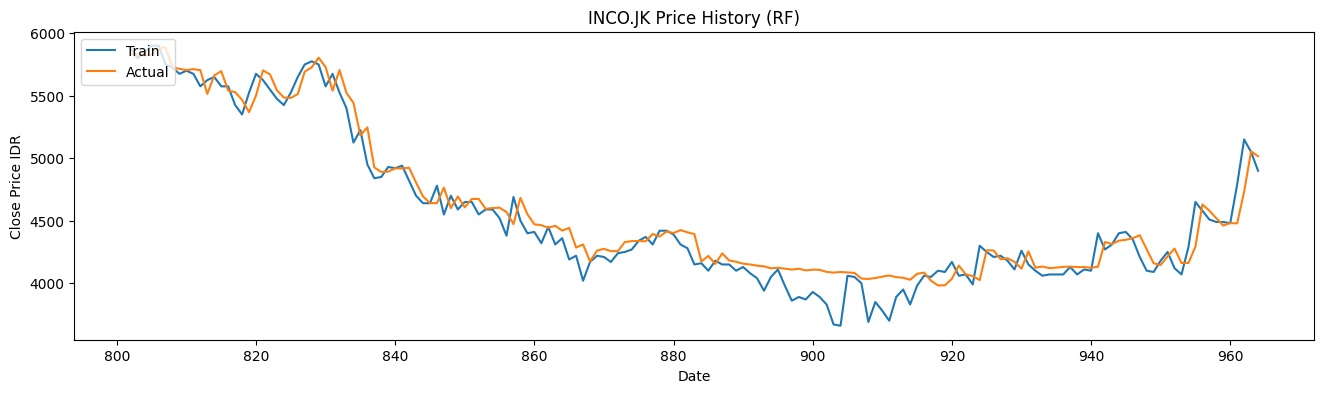

In [88]:
plt.figure(figsize=(16, 4))
plt.title(f'{ticker} Price History (RF)')
# plt.plot(train_price_plot_rf['Close'])
plt.plot(test_price_plot_rf[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
plt.legend(['Train', 'Actual', 'Prediction'], loc='upper left')
plt.show()

## **Plot Comparisons**

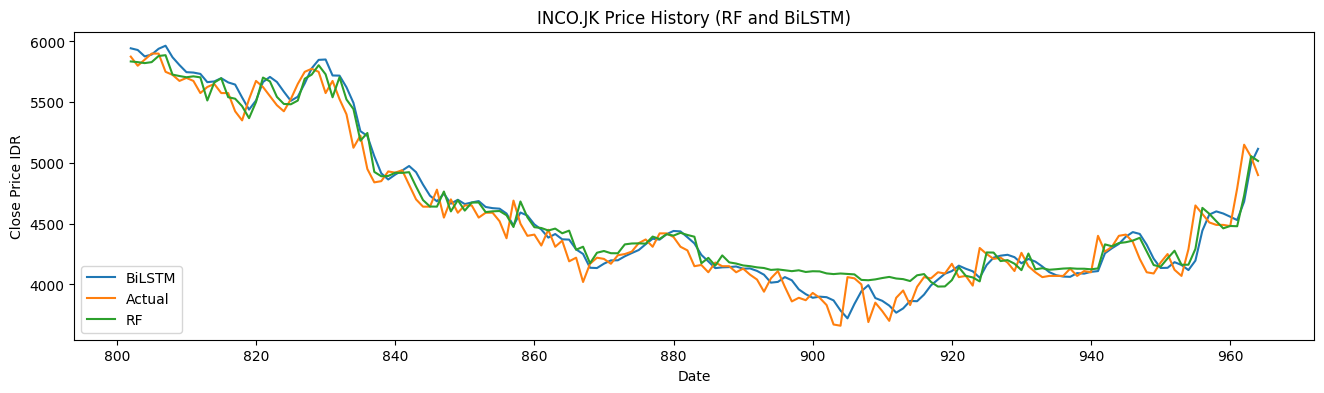

In [89]:
plt.figure(figsize=(16, 4))
plt.title(f'{ticker} Price History (RF and BiLSTM)')
# plt.plot(train_price_plot_rf['Close'])
plt.plot(test_price_plot[['Prediction']])
plt.plot(test_price_plot_rf[['Close']])
plt.plot(test_price_plot_rf[['Prediction']])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
plt.legend(['BiLSTM', 'Actual', 'RF'], loc='lower left')
plt.show()